In [18]:
import pandas as pd
from training.predictionAlgo import naiveNextEventPredictor
from preprocessing.dataParsing import parseData
from preprocessing.dataSplitting import dataSplitter

# Convert csv into dataframe
df_training_raw = pd.read_csv('.\data\BPI2012Training.csv')
df_test_raw = pd.read_csv('.\data\BPI2012Test.csv')

# Parsing data
(df_training, df_2012_last_event_per_case_train) = parseData(df_training_raw)
(df_test, df_2012_last_event_per_case_test) = parseData(df_test_raw)

# Clean and split the data into train, validation & test data
(df_training, df_validation, df_test) = dataSplitter(df_training, df_test)

In [19]:
from sklearn.preprocessing import OneHotEncoder

unique_training_events = df_training['event concept:name'].unique().reshape(-1, 1)

# Define One-hot encoder
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
onehot_encoder = onehot_encoder.fit(unique_training_events)

In [20]:
from math import ceil

number_events_mean = df_training.groupby('case concept:name').count()['event concept:name'].mean()
number_events_mean = ceil(number_events_mean)
number_events_mean

21

In [21]:
# Determine actual next event
(df_training, df_validation) = naiveNextEventPredictor(df_training, df_validation)

# training data with only relevant information for lstm training, i.e. one-hot encoded events
df_training_relevant = df_training[['case concept:name', 'event concept:name', 'actual_next_event']].copy()

# One-hot encode current and next event
training_current_event = df_training['event concept:name'].to_numpy().reshape(-1, 1)
df_training_relevant['event concept:name'] = onehot_encoder.transform(training_current_event).tolist()

training_next_event = df_training['actual_next_event'].to_numpy().reshape(-1, 1)
df_training_relevant['actual_next_event'] = onehot_encoder.transform(training_next_event).tolist()

# Prepare input and output in form of [samples, features]
x_train = []
y_train = []

# Get groupby object df by case id
df_training_groupby_case_id = df_training_relevant.groupby('case concept:name')

# Unique case ids
unique_case_ids = df_training_relevant['case concept:name'].unique().tolist()

# Find input and output vector in form of [samples, features]
for unique_id in unique_case_ids:
    xy_train_unique_id = df_training_groupby_case_id.get_group(unique_id)[['event concept:name', 'actual_next_event']].values.tolist()
    sequence_x_train_unique_id = []

    # event[0] = current event, event[1] = next event
    for event in xy_train_unique_id:
        if len(sequence_x_train_unique_id) == number_events_mean:
            del sequence_x_train_unique_id[0]
        sequence_x_train_unique_id.append(event[0])
        x_train.append(sequence_x_train_unique_id.copy())
        y_train.append(event[1])

In [22]:
print(x_train[0:10])
# print(y_train[:100])
# print(df_training_relevant)

[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 

In [23]:
# Find the maximum number of events in a case.
max_number_events_case_id = df_training.groupby('case concept:name').count().idxmax()[0]

max_number_events = df_training.groupby('case concept:name').count().max()[0]

df_training[df_training['case concept:name'] == max_number_events_case_id]

,case concept:name,eventID,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp,unix_abs_event_time,unix_reg_time,unix_rel_event_time,actual_next_event,naive_predicted_next_event
70632,185548,16333760626688,2011-11-15T13:42:45.592+01:00,20000,A_SUBMITTED,COMPLETE,15-11-2011 13:42:45.593,1.321361e+09,1.321361e+09,0.001,A_PARTLYSUBMITTED,A_PARTLYSUBMITTED
70633,185548,16333760626689,2011-11-15T13:42:45.592+01:00,20000,A_PARTLYSUBMITTED,COMPLETE,15-11-2011 13:42:45.889,1.321361e+09,1.321361e+09,0.297,A_PREACCEPTED,W_Afhandelen leads
70634,185548,16333760626690,2011-11-15T13:42:45.592+01:00,20000,A_PREACCEPTED,COMPLETE,15-11-2011 13:43:31.963,1.321361e+09,1.321361e+09,46.371,W_Completeren aanvraag,W_Completeren aanvraag
70635,185548,16333760626691,2011-11-15T13:42:45.592+01:00,20000,W_Completeren aanvraag,SCHEDULE,15-11-2011 13:43:32.557,1.321361e+09,1.321361e+09,46.965,W_Completeren aanvraag,W_Completeren aanvraag
70636,185548,16333760626692,2011-11-15T13:42:45.592+01:00,20000,W_Completeren aanvraag,START,15-11-2011 13:59:33.696,1.321362e+09,1.321361e+09,1008.104,W_Completeren aanvraag,W_Completeren aanvraag
...,...,...,...,...,...,...,...,...,...,...,...,...
70802,185548,16333760626858,2011-11-15T13:42:45.592+01:00,20000,W_Nabellen incomplete dossiers,COMPLETE,17-01-2012 10:54:42.893,1.326794e+09,1.321361e+09,5433117.301,W_Nabellen incomplete dossiers,W_Nabellen incomplete dossiers
70803,185548,16333760626859,2011-11-15T13:42:45.592+01:00,20000,W_Nabellen incomplete dossiers,START,17-01-2012 11:20:51.763,1.326796e+09,1.321361e+09,5434686.171,A_CANCELLED,W_Nabellen incomplete dossiers
70804,185548,16333760626860,2011-11-15T13:42:45.592+01:00,20000,A_CANCELLED,COMPLETE,17-01-2012 11:25:56.714,1.326796e+09,1.321361e+09,5434991.122,O_CANCELLED,O_CANCELLED
70805,185548,16333760626861,2011-11-15T13:42:45.592+01:00,20000,O_CANCELLED,COMPLETE,17-01-2012 11:25:56.714,1.326796e+09,1.321361e+09,5434991.122,W_Nabellen incomplete dossiers,O_SELECTED


In [24]:
from keras.preprocessing.sequence import pad_sequences
# Alter input to [samples, timestep, features] for lstm, zero padding used to equalize timestep length
x_train = pad_sequences(x_train)
x_train.shape

(193548, 21, 24)

In [25]:
import numpy as np
# Convert y_train to format [samples, features]
y_train = np.reshape(y_train, (-1, len(y_train[0])))

In [26]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

import os
import tensorflow as tf
from tensorflow import keras

CLASS_SIZE = unique_training_events.shape[0]

def model_fn(labels_dim):
    """Create a Keras Sequential model with layers."""
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(256, input_shape=(number_events_mean, unique_training_events.shape[0])))
    model.add(keras.layers.Dropout(0.20))
    model.add(keras.layers.Dense(labels_dim, activation='softmax'))
    model.summary()
    compile_model(model)
    return model

def compile_model(model):
    opt = keras.optimizers.Adagrad(lr=0.01)
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def get_latest(checkpoint_dir, filetype='.h5', signature='cp', overwrite=False):
    """ 
        This is a workaround as tf.train.latest_checkpoint does not seem to
        work well on codalab. Give preference to that function when possible.

        If overwrite is True, the latest checkpoint is reset to 0 and all 
        others are deleted.
    """
    latest = None
    latest_number = -1
    for filename in os.listdir(checkpoint_dir):
        reference, extension = os.path.splitext(filename)
        if extension == filetype and reference.startswith('cp'):
            number = int(re.sub(r"\D", "", reference))
            if number > latest_number:
                latest = filename
                latest_number = number
            else:
                if overwrite:
                    os.remove(os.path.join(checkpoint_dir, filename))
    if latest is None:
        raise ValueError('No previous checkpoint found.')
    if overwrite:
        os.rename(os.path.join(checkpoint_dir, latest), os.path.join(checkpoint_dir, 'cp-0000.h5'))
        latest = 'cp-0000.h5'
        shutil.rmtree(os.path.join(checkpoint_dir, 'logs')) 
    return os.path.join(checkpoint_dir, latest)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [27]:
# make predictions
# trainPredict = model.predict(train_x)
# testPredict = model.predict(testX)
# # invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])
# # calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))
# # shift train predictions for plotting
# trainPredictPlot = numpy.empty_like(dataset)
# trainPredictPlot[:, :] = numpy.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = numpy.empty_like(dataset)
# testPredictPlot[:, :] = numpy.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# # plot baseline and predictions
# plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

In [28]:
FILE_PATH="cp-{epoch:04d}.h5"
LSTM_MODEL = 'lstm.h5'

def run(num_epochs=20,  # Maximum number of epochs on which to train
        train_batch_size=128,  # Batch size for training steps
        job_dir='jobdir', # Local dir to write checkpoints and export model
        checkpoint_epochs='epoch',  #  Save checkpoint every epoch
        load_previous_model=False):
  
    """ This function trains the model for a number of epochs and returns the 
        training history. The model is periodically saved for later use.

        You can load a pre-trained model with 
            `model.load_weights(cp_path)`
        where `model` is a keras object (e.g. as returned by `model_fn`) and 
        `cp_path` is the path for the checkpoint you want to load.
        
        Setting load_previous_model to True will load the latest checkpoint in
        `job_dir` and continue training. That checkpoint is renamed cp-0000.h5,
        while all logs and other checkpoints are deleted. Use with care!
    
    """
    
    tf.keras.backend.clear_session()

    try:
        os.makedirs(job_dir)
    except:
        pass

    checkpoint_path = FILE_PATH
    checkpoint_path = os.path.join(job_dir, checkpoint_path)

    lstm_model = model_fn(CLASS_SIZE)
    if load_previous_model:
        # Load the previously saved weights
        latest = get_latest(job_dir, overwrite=True)
        lstm.load_weights(latest)
#         lstm_model.load_weights('jobdir\cp-0000.h5')

    # Model checkpoint callback
    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        verbose=2,
        save_freq=checkpoint_epochs,
        mode='max')

    # Tensorboard logs callback
    tblog = keras.callbacks.TensorBoard(
        log_dir=os.path.join(job_dir, 'logs'),
        histogram_freq=0,
        update_freq='epoch',
        write_graph=True,
        embeddings_freq=0)

#     #implemented earlystopping
#     callbacks = [checkpoint, tblog, keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6)]

    callbacks = [checkpoint, tblog]

    history = lstm_model.fit(
              x=x_train,
              y=y_train, 
              batch_size=train_batch_size,
              steps_per_epoch=None,
              epochs=num_epochs,
              callbacks=callbacks,
              verbose=2)
    
    lstm_model.save(os.path.join(job_dir, LSTM_MODEL))

    return history

In [29]:
history = run(load_previous_model=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               287744    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                6168      
Total params: 293,912
Trainable params: 293,912
Non-trainable params: 0
_________________________________________________________________
Train on 193548 samples
Epoch 1/20

Epoch 00001: saving model to jobdir\cp-0001.h5
193548/193548 - 14s - loss: 0.6898 - accuracy: 0.7375
Epoch 2/20

Epoch 00002: saving model to jobdir\cp-0002.h5
193548/193548 - 11s - loss: 0.4562 - accuracy: 0.7914
Epoch 3/20

Epoch 00003: saving model to jobdir\cp-0003.h5
193548/193548 - 12s - loss: 0.4474 - accuracy: 0.7924
Epoch 4/20

Epoch

KeyError: 'val_accuracy'

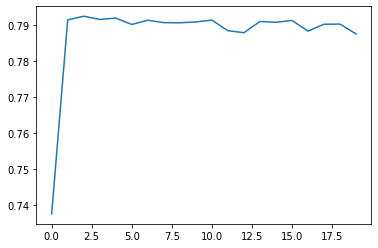

In [30]:
import matplotlib.pyplot as plt

# Plot history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

KeyError: 'val_loss'

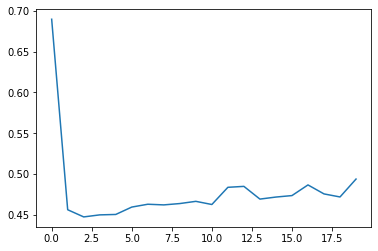

In [31]:
# Plot history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

In [17]:
# Or visualise using Tensorboard
%tensorboard --logdir jobdir/logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 4400.

In [ ]:
from keras import backend as K
K.clear_session()